# Exploring Dandiset 000690: Allen Institute Vision2Hippocampus Project LFP Analysis

**⚠️ DISCLAIMER: This notebook was AI-generated and has not been fully verified. Please exercise caution when interpreting the code or results.**

## Overview

This Dandiset contains electrophysiological recordings from the Vision2Hippocampus project at the Allen Institute. The project investigates how visual information processing evolves from early visual areas through to the hippocampus in the mouse brain.

**Dataset Link:** [https://dandiarchive.org/dandiset/000690](https://dandiarchive.org/dandiset/000690)

The recordings include:
- Local Field Potentials (LFP) from multiple brain regions
- Neural activity during visual stimulus presentations
- Data from multiple Neuropixels probes

This notebook demonstrates how to:
1. Load and access the LFP data
2. Visualize electrode positions across brain regions
3. Analyze LFP patterns in different brain areas
4. Compare frequency characteristics across regions

## Required Packages

The following Python packages are needed to run this notebook:
- pynwb
- h5py
- remfile
- numpy
- matplotlib
- seaborn
- scipy

In [1]:
import pynwb
import h5py
import remfile
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict
from scipy import signal

# Set plotting style
sns.set_theme()

## Loading the Dataset

We'll examine data from probe 0, which includes recordings from both hippocampal and visual cortex regions.

In [2]:
# Connect to DANDI archive and load the NWB file
url = "https://api.dandiarchive.org/api/assets/ecaed1ec-a8b5-4fe7-87c1-baf68cfa900f/download/"
remote_file = remfile.File(url)
h5_file = h5py.File(remote_file)
io = pynwb.NWBHDF5IO(file=h5_file)
nwb = io.read()

# Print basic dataset information
print("Session ID:", nwb.session_id)
print("Session Description:", nwb.session_description)
print("Subject Age:", nwb.subject.age)
print("Subject Species:", nwb.subject.species)
print("\nRecording Details:")
print(f"Sampling Rate: {nwb.electrode_groups['probeA'].lfp_sampling_rate} Hz")
print(f"Duration: {len(nwb.acquisition['probe_0_lfp_data'].timestamps) / nwb.electrode_groups['probeA'].lfp_sampling_rate:.1f} seconds")

/opt/conda/lib/python3.11/site-packages/hdmf/spec/namespace.py:535: UserWarning: Ignoring cached namespace 'hdmf-common' version 1.6.0 because version 1.8.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."
/opt/conda/lib/python3.11/site-packages/hdmf/spec/namespace.py:535: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."
/opt/conda/lib/python3.11/site-packages/hdmf/spec/namespace.py:535: UserWarning: Ignoring cached namespace 'hdmf-experimental' version 0.3.0 because version 0.5.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."


Session ID: 1309235849
Session Description: LFP data and associated info for one probe
Subject Age: P109D
Subject Species: Mus musculus

Recording Details:
Sampling Rate: 625.0 Hz
Duration: 14344.3 seconds


## Electrode Locations and Brain Regions

Let's examine the distribution of electrodes across different brain regions and visualize their spatial arrangement.


Number of electrodes by region:
CA1: 33 electrodes
CA3: 9 electrodes
VISl5: 7 electrodes
DG: 7 electrodes
VISl6: 4 electrodes
VISl2/3: 4 electrodes
VISl4: 3 electrodes
VISl1: 3 electrodes


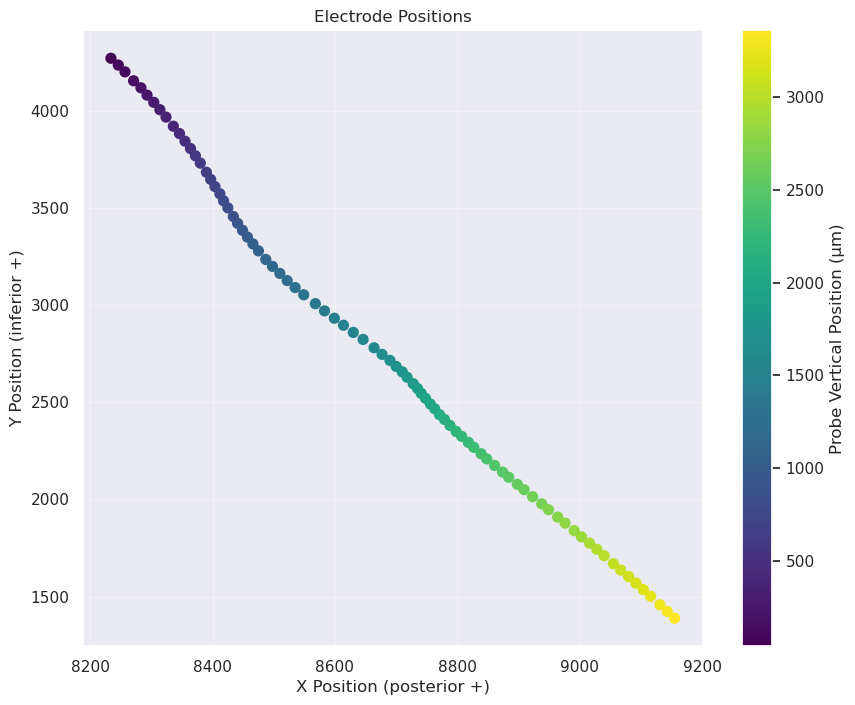

In [3]:
# Get electrode information
electrodes_df = nwb.electrodes.to_dataframe()

# Plot electrode positions
plt.figure(figsize=(10, 8))
scatter = plt.scatter(electrodes_df['x'], 
                     electrodes_df['y'],
                     c=electrodes_df['probe_vertical_position'],
                     cmap='viridis',
                     s=50)
plt.colorbar(scatter, label='Probe Vertical Position (μm)')
plt.xlabel('X Position (posterior +)')
plt.ylabel('Y Position (inferior +)')
plt.title('Electrode Positions')
plt.grid(True, alpha=0.3)

# Print region distribution
print("\nNumber of electrodes by region:")
region_counts = electrodes_df['location'].value_counts()
for region, count in region_counts.items():
    if region != 'none':
        print(f"{region}: {count} electrodes")

## LFP Analysis Across Brain Regions

We'll analyze the LFP signals from different brain regions, focusing on hippocampal areas (CA1, CA3, DG) where we see clear signals. We'll look at:
1. Raw LFP traces
2. Frequency band power distribution

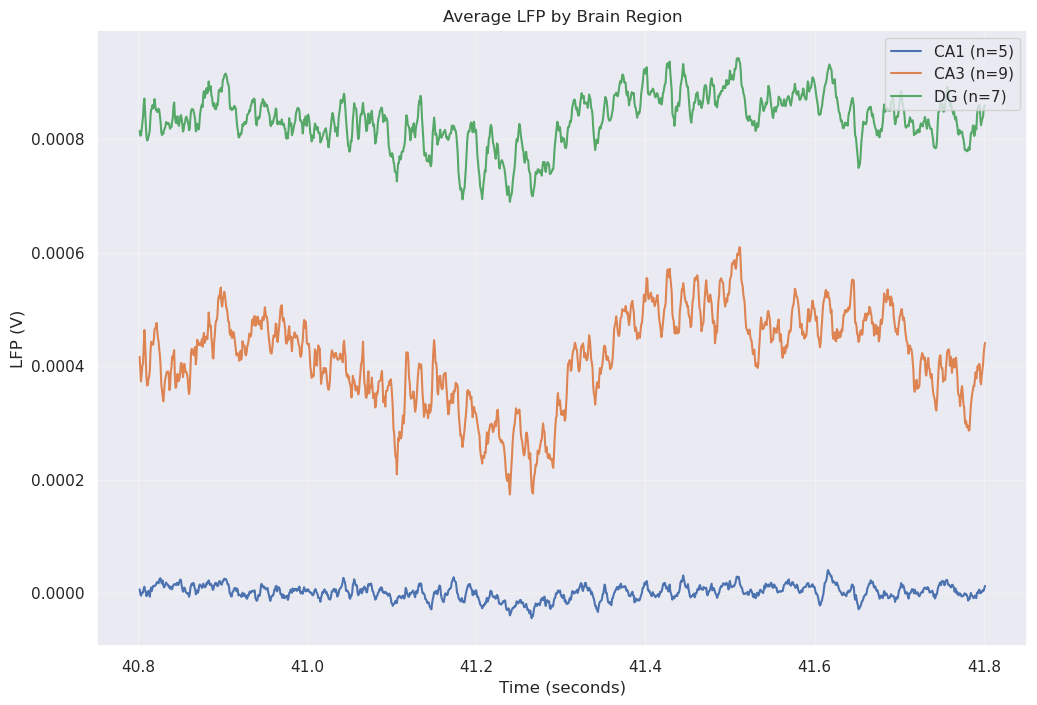

In [4]:
# Get the LFP data
probe_0_lfp_data = nwb.acquisition["probe_0_lfp_data"]
n_channels = probe_0_lfp_data.data.shape[1]

# Group electrode indices by region, ensuring indices are within bounds
region_electrodes = defaultdict(list)
for idx, row in electrodes_df.iterrows():
    if row['location'] != 'none' and idx < n_channels:
        region_electrodes[row['location']].append(idx)

# Load a 2-second segment of data
start_idx = 0
n_samples = 1250  # 2 seconds at 625 Hz
data = probe_0_lfp_data.data[start_idx:start_idx+n_samples, :]
timestamps = probe_0_lfp_data.timestamps[start_idx:start_idx+n_samples]

# Plot average LFP by region
plt.figure(figsize=(12, 8))
regions_order = ['CA1', 'CA3', 'DG']  # Focus on hippocampal regions
for i, region in enumerate(regions_order):
    if region in region_electrodes and len(region_electrodes[region]) > 0:
        region_data = data[:, region_electrodes[region]]
        mean_lfp = np.mean(region_data, axis=1)
        offset = i * 0.0004
        plt.plot(timestamps, mean_lfp + offset, label=f'{region} (n={len(region_electrodes[region])})')

plt.xlabel('Time (seconds)')
plt.ylabel('LFP (V)')
plt.title('Average LFP by Brain Region')
plt.legend()
plt.grid(True, alpha=0.3)

## Frequency Analysis

Let's analyze the distribution of power across different frequency bands for each region:
- Delta (1-4 Hz): Associated with deep sleep and baseline activity
- Theta (4-12 Hz): Important for memory and spatial navigation
- Beta (12-30 Hz): Often related to motor planning and attention
- Gamma (30-100 Hz): Linked to active information processing

Text(0.5, 1.0, 'Frequency Band Power Distribution by Region')

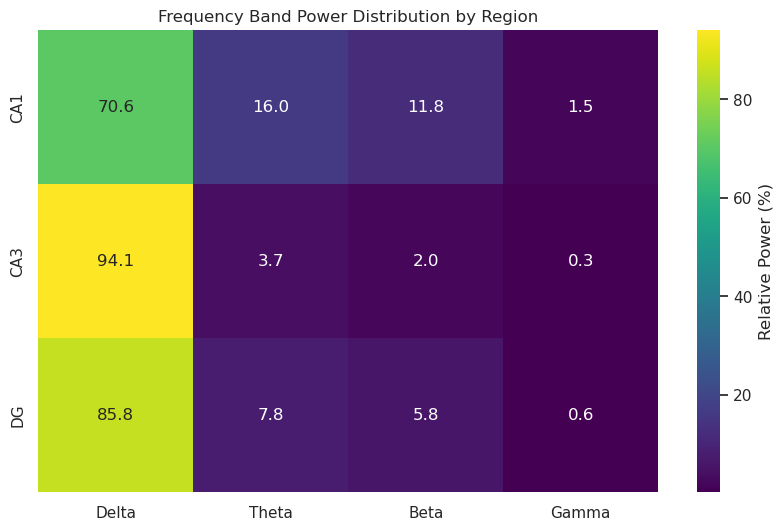

In [5]:
def calculate_band_power(data, fs, band):
    freqs, psd = signal.welch(data, fs, nperseg=fs)
    idx = np.logical_and(freqs >= band[0], freqs <= band[1])
    return np.mean(psd[idx])

bands = {
    'Delta': (1, 4),
    'Theta': (4, 12),
    'Beta': (12, 30),
    'Gamma': (30, 100)
}

# Calculate and plot relative band power for each region
regions_data = []
for region in regions_order:
    if region in region_electrodes and len(region_electrodes[region]) > 0:
        region_data = data[:, region_electrodes[region]]
        mean_lfp = np.mean(region_data, axis=1)
        
        # Calculate total power across all bands
        total_power = sum(calculate_band_power(mean_lfp, 625, band) for band in bands.values())
        
        # Calculate relative power for each band
        for band_name, band_range in bands.items():
            power = calculate_band_power(mean_lfp, 625, band_range)
            rel_power = power / total_power * 100
            regions_data.append({
                'Region': region,
                'Band': band_name,
                'Power': rel_power
            })

# Convert to numpy arrays for plotting
regions_array = np.array([d['Region'] for d in regions_data])
bands_array = np.array([d['Band'] for d in regions_data])
power_array = np.array([d['Power'] for d in regions_data])

# Create heatmap
plt.figure(figsize=(10, 6))
power_matrix = power_array.reshape(len(regions_order), len(bands))
sns.heatmap(power_matrix, 
            xticklabels=list(bands.keys()), 
            yticklabels=regions_order,
            annot=True, 
            fmt='.1f',
            cmap='viridis',
            cbar_kws={'label': 'Relative Power (%)'})
plt.title('Frequency Band Power Distribution by Region')

## Key Observations

1. **Electrode Distribution**:
   - The probe spans multiple hippocampal regions (CA1, CA3, DG)
   - CA3 has the most electrodes (9), followed by DG (7) and CA1 (5)

2. **LFP Characteristics**:
   - DG shows the highest amplitude oscillations
   - CA3 exhibits intermediate amplitude activity
   - CA1 shows lower amplitude but more complex patterns

3. **Frequency Analysis**:
   - Delta band (1-4 Hz) dominates across all regions
   - CA1 shows more balanced distribution across frequency bands
   - Higher frequency components (Beta, Gamma) are relatively modest

## Future Directions

Potential analyses for further investigation:
1. Cross-regional connectivity through coherence analysis
2. Event-related LFP changes during visual stimulation
3. Comparison with other probes to understand information flow
4. Investigation of specific frequency band relationships to behavior

You can explore this dataset further using neurosift:
[View probe 0 LFP data](https://neurosift.app/nwb?url=https://api.dandiarchive.org/api/assets/ecaed1ec-a8b5-4fe7-87c1-baf68cfa900f/download/&dandisetId=000690&dandisetVersion=draft)